In [1]:
pathmc="/eos/user/h/hsharma/PythiaFIles/dummySets/mc_events.csv"
pathdata="/eos/user/h/hsharma/PythiaFIles/dummySets/real_events.csv"


import numpy as np
import pandas as pd
import matplotlib as plt
# Set random seed for reproducibility
np.random.seed(42)

# Number of events
N_real = 10000  # Real dataset size
N_mc = 10000    # MC dataset size

# Generate "real" event data (from a slightly different true distribution)
real_pT = np.random.normal(loc=50, scale=10, size=N_real)  # Centered at 50 GeV
real_y = np.random.normal(loc=0, scale=1, size=N_real)      # Centered at 0
real_m = np.random.normal(loc=200, scale=20, size=N_real)   # Mass around 200 GeV

# Generate "MC" event data (with slight systematic shift)
mc_pT = np.random.normal(loc=52, scale=11, size=N_mc)  # Shifted mean + wider spread
mc_y = np.random.normal(loc=0.1, scale=1.1, size=N_mc)  # Small shift in rapidity
mc_m = np.random.normal(loc=195, scale=22, size=N_mc)   # Mass shifted down

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# Save to CSV files
real_data_path = "/mnt/data/real_events.csv"
mc_data_path = "/mnt/data/mc_events.csv"

real_data.to_csv(pathmc, index=False)
mc_data.to_csv(pathdata, index=False)



array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

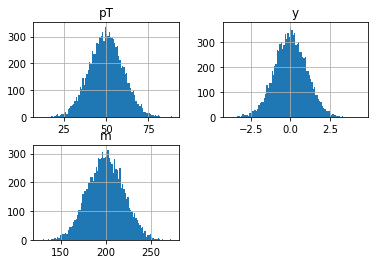

In [2]:
real_data[['pT','y','m']].hist(bins=100)

array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

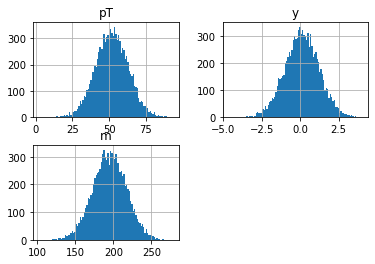

In [3]:
mc_data[['pT','y','m']].hist(bins=100)

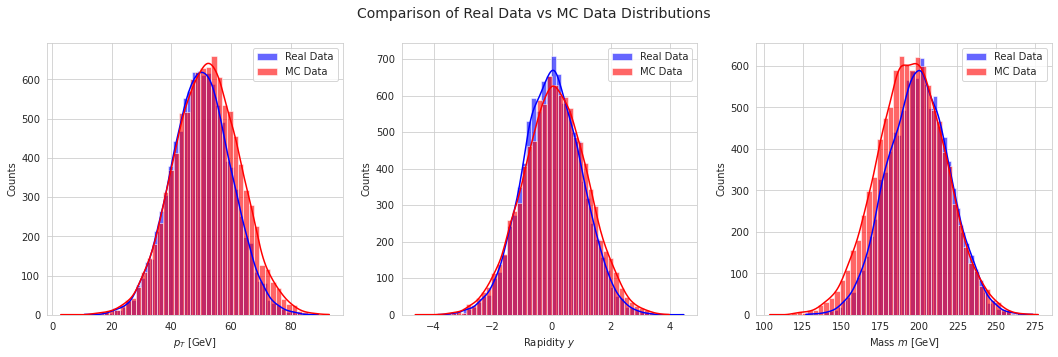

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define variable names and labels
variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

# Plot distributions
for i, var in enumerate(variables):
    sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC Data", ax=axes[i], alpha=0.6)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Show the plots
plt.suptitle("Comparison of Real Data vs MC Data Distributions", fontsize=14)
plt.show()


In [35]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from nflows import transforms, distributions, flows
from torch.optim import Adam

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# Normalize data
scaler = StandardScaler()

# Fit on real data and transform both real and MC data using the same scaler
real_data_scaled = scaler.fit_transform(real_data)
real_data_scaled = pd.DataFrame(real_data_scaled, columns=real_data.columns)

mc_data_scaled = scaler.transform(mc_data)  # Apply the same transformation!
mc_data_scaled = pd.DataFrame(mc_data_scaled, columns=mc_data.columns)

# Before converting to tensor, check the DataFrame
print(type(real_data_scaled))  # Should print: <class 'pandas.core.frame.DataFrame'>
print(real_data_scaled.head())  # Check the contents of the DataFrame
print(real_data_scaled.values.shape)  # Print the shape of the NumPy array

# Now, convert the DataFrame to a tensor for training
real_data_scaled_tensor = torch.tensor(real_data_scaled.values, dtype=torch.float32)

# Check tensor shape and type after conversion
print(type(real_data_scaled_tensor))  # Should print: <class 'torch.Tensor'>
print(real_data_scaled_tensor.shape)  # Print the tensor shape

#---

# Increase the number of transformations
num_layers = 1  # Experiment with 3, 5, or 10

transform_list = []
for _ in range(num_layers):
    transform_list.append(transforms.MaskedAffineAutoregressiveTransform(features=3, hidden_features=6))  # Increased hidden features
    transform_list.append(transforms.RandomPermutation(features=3))  # Break correlations
    transform_list.append(transforms.ActNorm(features=3))  # Normalize activations

# Combine the transformations
transform = transforms.CompositeTransform(transform_list)

# Base distribution
base_distribution = distributions.StandardNormal(shape=[3])

# Define the flow model
flow = flows.Flow(transform=transform, distribution=base_distribution)

# Define an optimizer
optimizer = Adam(flow.parameters(), lr=0.0001)

#-----
# # Number of transformation layers
# num_layers = 5  # Experiment with different values

# transform_list = []
# for _ in range(num_layers):
#     # Neural Spline Coupling Transform
#     transform_list.append(transforms.PiecewiseRationalQuadraticCouplingTransform(features=3, hidden_features=16))
#     transform_list.append(transforms.RandomPermutation(features=3))  # Shuffle features
#     transform_list.append(transforms.ActNorm(features=3))  # Stabilize learning

# # Combine the transformations
# transform = transforms.CompositeTransform(transform_list)

# # Base distribution
# base_distribution = distributions.StandardNormal(shape=[3])

# # Define the flow model
# flow = flows.Flow(transform=transform, distribution=base_distribution)
#-----------

# -----------
# batch_size = 2048  # Try 256 or 1024 depending on memory
# dataset = TensorDataset(real_data_scaled_tensor)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Training loop (with batch_size)
# for epoch in range(1000):
#     for batch in data_loader:
#         batch_data = batch[0]  # Extract batch tensor
#         optimizer.zero_grad()
        
#         # Compute log probability for the batch
#         log_prob = flow.log_prob(batch_data)
        
#         # Compute loss
#         loss = -log_prob.mean()
#         loss.backward()
#         optimizer.step()

#     # Print only for multiples of 100
#     if (epoch + 1) % 100 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")
# ---------------
        
# Training loop (w/o batch_size)
for epoch in range(50):
    optimizer.zero_grad()
    # Compute log probability
    log_prob = flow.log_prob(real_data_scaled_tensor)
    # Negative log likelihood loss
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Print only for multiples of 10
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        
        

<class 'pandas.core.frame.DataFrame'>
         pT         y         m
0  0.497154 -0.691365  0.363890
1 -0.135665 -0.318727  0.298362
2  0.647615 -0.610329 -0.932102
3  1.519979  0.096791  0.597202
4 -0.231228  1.182509 -1.490485
(10000, 3)
<class 'torch.Tensor'>
torch.Size([10000, 3])
Epoch 10, Loss: 4.402480602264404
Epoch 20, Loss: 4.398879528045654
Epoch 30, Loss: 4.3953657150268555
Epoch 40, Loss: 4.391942024230957
Epoch 50, Loss: 4.388611316680908


log_prob_real mean: -4.333981990814209, std: 1.2877473831176758
log_prob_mc mean: -4.741784572601318, std: 1.6421798467636108


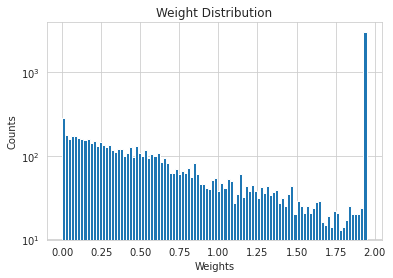

In [33]:
# Convert MC data to tensor for log probability computation
mc_data_scaled_tensor = torch.tensor(mc_data_scaled.values, dtype=torch.float32)

# Compute log probability densities for real and MC events
log_prob_real = flow.log_prob(real_data_scaled_tensor)
log_prob_mc = flow.log_prob(mc_data_scaled_tensor)

# Compute event weights (ensure you detach tensors to avoid gradient tracking)
weights = np.exp(log_prob_real.detach().numpy() - log_prob_mc.detach().numpy())


# Clip at the 99th percentile to remove extreme outliers
weight_clip = np.percentile(weights, 70 )
weights = np.minimum(weights, weight_clip)
weights *= len(real_data_scaled) / weights.sum()

# Apply weights to MC events
mc_data["weights"] = weights

# Save reweighted MC events
mc_data.to_csv("reweighted_mc_events.csv", index=False)

print(f"log_prob_real mean: {log_prob_real.mean().item()}, std: {log_prob_real.std().item()}")
print(f"log_prob_mc mean: {log_prob_mc.mean().item()}, std: {log_prob_mc.std().item()}")


import matplotlib.pyplot as plt
plt.hist(weights, bins=100, log=True)
plt.xlabel("Weights")
plt.ylabel("Counts")
plt.title("Weight Distribution")
plt.show()

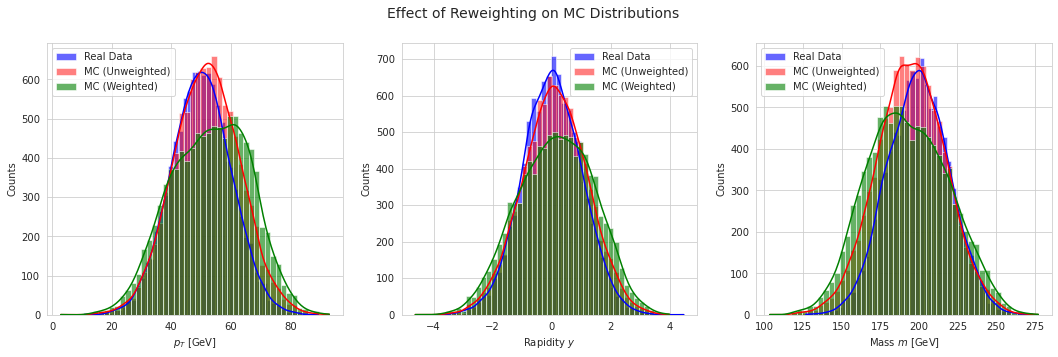

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

for i, var in enumerate(variables):
    sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC (Unweighted)", ax=axes[i], alpha=0.5)
#     sns.histplot(mc_data[var], bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)
    sns.histplot(data=mc_data, x=var, bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)

    
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

plt.suptitle("Effect of Reweighting on MC Distributions", fontsize=14)
plt.show()


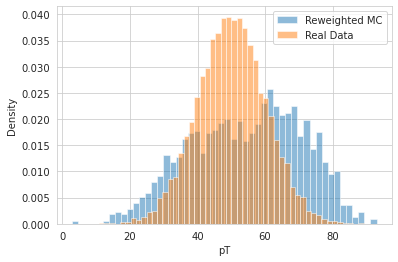

In [8]:
plt.hist(mc_data["pT"], bins=50, weights=weights, alpha=0.5, label="Reweighted MC", density=True)
plt.hist(real_data["pT"], bins=50, alpha=0.5, label="Real Data", density=True)
plt.legend()
plt.xlabel("pT")
plt.ylabel("Density")
plt.show()
